<a href="https://colab.research.google.com/github/KJ-black/Machine-Learning-on-Material-Informatics/blob/main/projectile_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Collection

## Data Generation

In [73]:
import numpy as np
import random
import pandas as pd

n = 100000 # number of dataset
data = []
title = ['angle', 'velocity', 'height', 'distance']
for i in range(n):
  angle = random.uniform(0, np.pi/2)
  v = random.uniform(0, 100)
  h = ((v*np.sin(angle))**2)/(2*9.8)
  d = (v**2*2*np.sin(angle)*np.cos(angle))/9.8
  data.append([angle, v, h, d])
data = np.array(data)
pd_data = pd.DataFrame(data, columns=title)
print(data.shape)

(100000, 4)


## Original Data Visiualization

### Input Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdd5e98f90>,
      dtype=object)

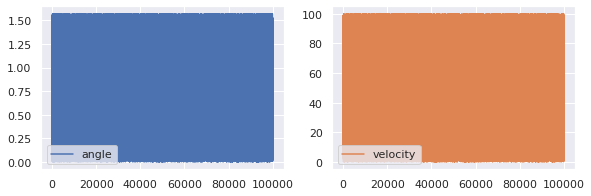

In [65]:
pd_data[['angle', 'velocity']].plot(subplots=True, layout=(1, 4), figsize=(20, 3))

Output Data (Target Data)

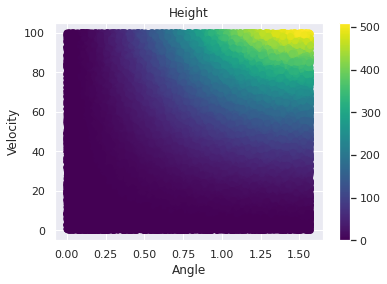

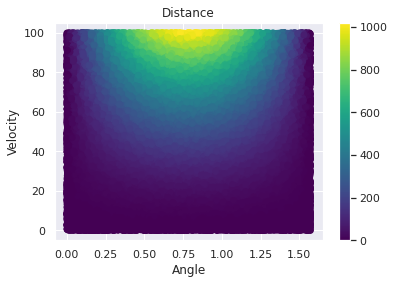

In [76]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Height")
plt.xlabel("Angle")
plt.ylabel("Velocity")
plt.scatter(data[:,0], data[:, 1], c=data[:,2], cmap="viridis")
plt.colorbar()
plt.show()

plt.figure()
plt.title("Distance")
plt.xlabel("Angle")
plt.ylabel("Velocity")
plt.scatter(data[:,0], data[:, 1], c=data[:,3], cmap="viridis")
plt.colorbar()
plt.show()